# Look at these Repos
https://mne.tools/dev/auto_tutorials/inverse/60_visualize_stc.html#sphx-glr-auto-tutorials-inverse-60-visualize-stc-py

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import pickle
import copy

import mne
from mne import Epochs, pick_channels, find_events
from mne.io import read_raw_bdf, concatenate_raws
from mne.time_frequency import tfr_morlet

import collections
from autoreject import AutoReject

import sys
sys.path.append('/Users/nick/Documents/PhD/CLCT/NeuroTracker/')
from cda_utils import get_epochs, get_CDA, prep_report, fill_report, get_report, checksum, add_cda_report, get_CDA_perf_report
#from events import get_specific_events

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#==================================================================
# General Variables
#==================================================================
# Organize Triggers
trigger = 2

# Triggers
# 1 - New Spheres.
# 2 - Red Spheres.
# 4 - Start Moving.
# 8 - Stop Moving.
# 16 - TBD (~4 of them... and 4 blocks.)
# 32 - TBD (juste juste avant le 1, so I guess fin de trial, I have 88 of them... 4 trials)
# 

# T2 = T1 + 5s 
# T4 = T2 + 2s
# T8 = T4 + 9s ?! (9s ?)
# T16 = T8 + ~1s
# T32 = T8 + 25s   ensuite un autre 3s plus tard.

# Beaucoup de 1 et 32.. pas clair...

# --------------------------
conds = ['1', '2', '3']
sides = ['right', 'left', 'classicmod']
perfs = ['good', 'bad']

custom_trigger = dict()
custom_trigger['1'] = 100
custom_trigger['2'] = 200
custom_trigger['3'] = 300
custom_trigger['right'] = 10
custom_trigger['left'] = 20
custom_trigger['classicmod'] = 30
custom_trigger['good'] = 1
custom_trigger['bad'] = 2

#report = prep_report(conds, sides, perfs)

# Making Event ID Dict to make it easy and readable to access (the desired) epochs.
event_id = dict()
for cond in conds:
    for side in sides:
        for perf in perfs:
            event_id['{}/{}/{}'.format(cond, side, perf)] = custom_trigger[cond] + custom_trigger[side] + custom_trigger[perf]

# CDA Channels
chan_right_all = ['O2', 'PO4', 'PO8', 'P2', 'P4', 'P6', 'P8', 'P10', 'C2', 'C4', 'C6', 'CP2', 'CP4', 'CP6', 'T8', 'TP8', 'FT8', 'FC2', 'FC4', 'FC6', 'F2', 'F4', 'F6', 'F8', 'AF4', 'AF8', 'Fp2']
chan_left_all =  ['O1', 'PO3', 'PO7', 'P1', 'P3', 'P5', 'P7', 'P9',  'C1', 'C3', 'C5', 'CP1', 'CP3', 'CP5', 'T7', 'TP7', 'FT7', 'FC1', 'FC3', 'FC5', 'F1', 'F3', 'F5', 'F7', 'AF3', 'AF7', 'Fp1']
chan_midline_all = ['Fz', 'FCz', 'Cz', 'Fpz', 'CPz', 'Pz', 'POz', 'Oz'] #'Iz'

clusters = ['F', 'P', 'C', 'O', 'T']
clusters_names = {'F':'Frontal', 'P':'Parietal', 'C':'Central', 'O':'Occipital', 'T':'Temporal'}


# Epoch Information
epoch_length = 20
epoch_tmin = -3
baseline_corr = (-1, -0.6)

# Epochs variable!
preproc_dict_all = dict()
events_dict_all = dict()
epochs_dict_all = dict()
rt_dict_all = dict()

cda_cluster_all = dict()



In [250]:
#raw = read_raw_bdf("/Volumes/Cortex/PhD/Open Datasets/Data/AP140119.bdf", preload=True)
raw = read_raw_bdf("/Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Sub/T23F1.bdf", preload=True)

raw = raw.drop_channels(ch_names=['EXG1','EXG2','EXG3','EXG6','EXG7', 'EXG8'])
raw = raw.set_eeg_reference(ref_channels=['EXG4', 'EXG5'])
raw = raw.set_channel_types({'EXG4': 'misc', 'EXG5': 'misc'})

# Set Electrodes Locations
montage = mne.channels.make_standard_montage('biosemi64')
raw.set_montage(montage)

# Sampling Frequency
sfreq = raw.info['sfreq']

# Events 
events = find_events(raw)

#Max Events in File...
#---------------------------
#32: 88
#1:  172
#2:  84
#4:  84
#8:  84
#16: 4
#---------------------------

# Triggers
# 1 - New Spheres.
# 2 - Red Spheres.
# 4 - Start Moving.
# 8 - Stop Moving.
# 16 - TBD
# 32 - TBD (juste juste avant le 1, so I guess fin de trial)

Extracting EDF parameters from /Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Sub/T23F1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6590463  =      0.000 ...  3218.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
516 events found
Event IDs: [ 1  2  4  8 16 32]


In [251]:
total = 0
frequency = collections.Counter(events[:,2])
events_frequency = dict(frequency)

print('Max Events in File...')
print("---------------------------")
for e in set(events[:,2]):
    print("{}: \t\t{}".format(e, frequency[e]))
print("---------------------------")

Max Events in File...
---------------------------
32: 		88
1: 		172
2: 		84
4: 		84
8: 		84
16: 		4
---------------------------


Setting up low-pass filter at 40 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 40.00 Hz: -6.02 dB



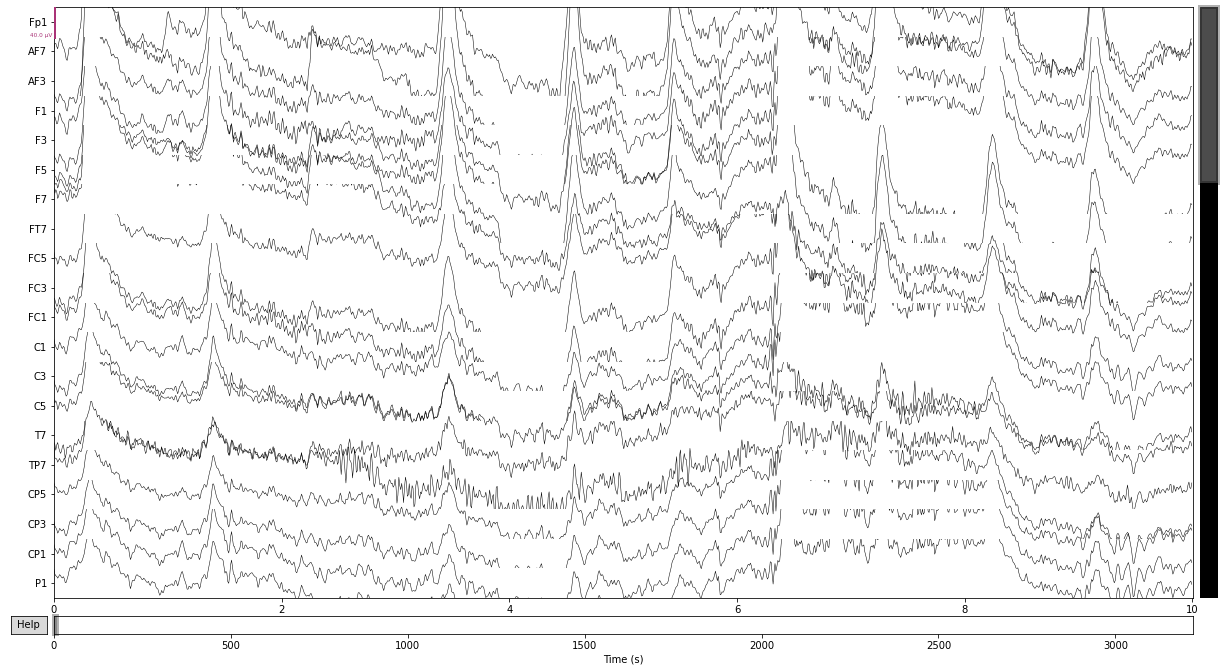

In [252]:
x = raw.plot(events=events, block=True, lowpass=40)

In [253]:
df_behav = pd.read_csv('/Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Sub/T23F1.csv', sep=',')
df_behav

,#Trial,Synch,NbTargets,NbDistractors,Speed,Mode,Wallsize,Results,[TID_Entered_1],[TID_Entered_2],...,MiddleTimeCross.3,Ball Id.4,TimeCross,Ball Id.5,TimeCross.1,Ball Id.6,TimeCross.2,Ball Id.7,TimeCross.3,Unnamed: 36
0,1,True,3,5,0.6,Left,10,0,1,2,...,--,--,--,--,--,--,--,--,--,NaN
1,2,False,1,7,0.6,Left,10,1,8,0,...,--,--,--,--,--,--,--,--,--,NaN
2,3,False,1,7,0.6,ClassicMod,10,1,2,0,...,--,--,--,--,--,--,--,--,--,NaN
3,4,False,2,6,0.6,Left,10,1,7,5,...,--,--,--,--,--,--,--,--,--,NaN
4,5,False,2,6,0.6,Right,10,2,6,8,...,--,--,--,--,--,--,--,--,--,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,17,False,3,5,0.5,Right,10,3,2,5,...,--,--,--,--,--,--,--,--,--,NaN
80,18,False,1,7,0.5,Left,10,1,4,0,...,--,--,--,--,--,--,--,--,--,NaN
81,19,False,1,7,0.5,Right,10,1,4,0,...,--,--,--,--,--,--,--,--,--,NaN
82,20,True,2,6,0.5,Left,10,2,8,2,...,--,--,--,--,--,--,--,--,--,NaN


In [254]:
new_events = []
nb_trials = 0
total_skipped = 0
for e in events:
    cur_cond = None
    cur_side = None
    cur_perf = None
    if e[2] == 2: # Find Start of Trial
        cur_cond = str(df_behav['NbTargets'].values[nb_trials]).lower()
        cur_side = str(df_behav['Mode'].values[nb_trials]).lower()
        cur_perf = 'good' if (int(df_behav['NbTargets'].values[nb_trials]) == int(df_behav['Results'].values[nb_trials])) else 'bad'
        if cur_cond is not None and cur_side is not None and cur_perf is not None:
            #temp_trigger = int(custom_trigger[cur_cond]) + int(custom_trigger[cur_side]) + int (custom_trigger[cur_perf])
            temp_event = [e[0], e[1], event_id['{}/{}/{}'.format(cur_cond, cur_side, cur_perf)]]
            new_events.append(temp_event) # Make a new list of events with new custom triggers.
        else:
            total_skipped = total_skipped + 1
            print('Skipping this event {}: No Cond or Side or Perf'.format(e))

        nb_trials = nb_trials + 1
        
# Calculate average response time.
resp_time_in_ticks = []
for i, e in enumerate(events):
    if e[2] == 8:
        if events[i+1,2] == 32:
            resp_time_in_ticks.append(events[i+1,0] - events[i,0])
        elif events[i+1,2] == 16: #Synch?!
            if events[i+2,2] == 32:
                resp_time_in_ticks.append(events[i+2,0] - events[i,0])
            else:
                print('No Response?! Trigger: {}'.format(events[i+1,2]))
        else:
            print('No Response?! Trigger: {}'.format(events[i+1,2]))

mean_rt = np.mean(resp_time_in_ticks)
std_rt = np.std(resp_time_in_ticks)
print('Response Time ~{:.2f}s (std:{:.2f})'.format(mean_rt/sfreq, std_rt/sfreq))

print("A total of {} trials were added and {} were skipped.".format(nb_trials, total_skipped))

Response Time ~7.37s (std:4.70)
A total of 84 trials were added and 0 were skipped.


In [255]:
tmin = -3
tmax = 20
baseline_corr = (-2.5, -2)

print('==================================================')
print('REMOVING EVENTS ID NOT IN EEG FILE...')
cur_event_id = copy.deepcopy(event_id)
newevents_in_file = set(np.array(new_events)[:,2])
keys_to_delete = []
for e in cur_event_id.keys():
    if event_id[e] not in newevents_in_file:
        print('Event: {} ({}), not present.'.format(e, event_id[e]))
        keys_to_delete.append(e)
for key in keys_to_delete:
    del cur_event_id[key]
print('==================================================')  

epochs = Epochs(raw, new_events, event_id=cur_event_id, tmin=tmin, tmax=tmax, baseline=baseline_corr, preload=True, event_repeated='merge', on_missing='warn')

epochs

REMOVING EVENTS ID NOT IN EEG FILE...
Event: 1/left/bad (122), not present.
Not setting metadata
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events and 47105 original time points ...
0 bad epochs dropped


Number of events,84
Events,1/classicmod/bad: 21/classicmod/good: 61/left/good: 101/right/bad: 11/right/good: 92/classicmod/bad: 32/classicmod/good: 52/left/bad: 22/left/good: 82/right/bad: 32/right/good: 73/classicmod/bad: 43/classicmod/good: 43/left/bad: 73/left/good: 33/right/bad: 73/right/good: 3
Time range,-3.000 – 20.000 sec
Baseline,-2.500 – -2.000 sec


Need more than one channel to make topography for eeg. Disabling interactivity.


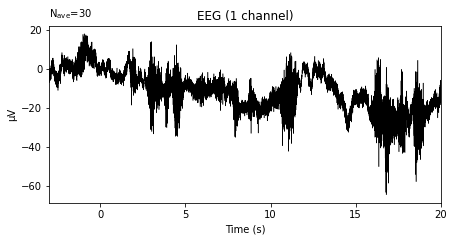

Need more than one channel to make topography for eeg. Disabling interactivity.


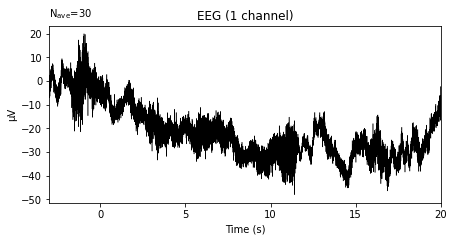

In [256]:
epochs_right = epochs['right'].pick_channels(['T8'])
epochs_left = epochs['right'].pick_channels(['T7'])

evoked_right = epochs_right.average().plot() #.data
evoked_left = epochs_left.average().plot() #.data

#cda = evoked_right - evoked_left

#plt.plot(times, cda)

Running autoreject on ch_type=eeg


100%|█████████████████████████████████| Creating augmented epochs : 64/64 [00:46<00:00,    1.38it/s]
100%|██████████████████████████████████| Computing thresholds ... : 64/64 [13:01<00:00,   12.21s/it]


  0%|                                               | Repairing epochs : 0/84 [00:00<?,       ?it/s]

  4%|█▌                                         | Repairing epochs : 3/84 [00:00<00:00,  177.31it/s]

  7%|███                                        | Repairing epochs : 6/84 [00:00<00:00,  161.20it/s]

 11%|████▌                                      | Repairing epochs : 9/84 [00:00<00:00,  157.93it/s]

 14%|██████                                    | Repairing epochs : 12/84 [00:00<00:00,  160.73it/s]

 18%|███████▌                                  | Repairing epochs : 15/84 [00:00<00:00,  161.64it/s]

 21%|█████████                                 | Repairing epochs : 18/84 [00:00<00:00,  161.24it/s]

 25%|██████████▌                               | Repairing epochs : 21/84 [00:00<0

 52%|██████████████████████                    | Repairing epochs : 44/84 [00:01<00:00,   46.14it/s]

 54%|██████████████████████▌                   | Repairing epochs : 45/84 [00:01<00:00,   46.35it/s]

 55%|███████████████████████                   | Repairing epochs : 46/84 [00:01<00:00,   46.41it/s]

 56%|███████████████████████▌                  | Repairing epochs : 47/84 [00:01<00:00,   46.82it/s]

 57%|████████████████████████                  | Repairing epochs : 48/84 [00:01<00:00,   46.46it/s]

 58%|████████████████████████▌                 | Repairing epochs : 49/84 [00:01<00:00,   46.91it/s]

 60%|█████████████████████████                 | Repairing epochs : 50/84 [00:01<00:00,   47.37it/s]

 61%|█████████████████████████▍                | Repairing epochs : 51/84 [00:01<00:00,   47.47it/s]

 62%|██████████████████████████                | Repairing epochs : 52/84 [00:01<00:00,   47.31it/s]

 63%|██████████████████████████▌               | Repairing epochs : 53/84 [00:01<0

  0%|                                               | Repairing epochs : 0/84 [00:00<?,       ?it/s]

  1%|▌                                          | Repairing epochs : 1/84 [00:00<00:01,   55.56it/s]

  2%|█                                          | Repairing epochs : 2/84 [00:00<00:01,   51.64it/s]

  4%|█▌                                         | Repairing epochs : 3/84 [00:00<00:01,   47.39it/s]

  5%|██                                         | Repairing epochs : 4/84 [00:00<00:01,   47.53it/s]

  6%|██▌                                        | Repairing epochs : 5/84 [00:00<00:01,   46.13it/s]

  7%|███                                        | Repairing epochs : 6/84 [00:00<00:01,   45.43it/s]

  8%|███▌                                       | Repairing epochs : 7/84 [00:00<00:01,   45.31it/s]

 10%|████                                       | Repairing epochs : 8/84 [00:00<00:01,   45.66it/s]

 11%|████▌                                      | Repairing epochs : 9/84 [00:00<0





Estimated consensus=0.70 and n_interpolate=32




  0%|                                               | Repairing epochs : 0/84 [00:00<?,       ?it/s]

  1%|▌                                          | Repairing epochs : 1/84 [00:00<00:01,   57.32it/s]

  2%|█                                          | Repairing epochs : 2/84 [00:00<00:01,   53.14it/s]

  4%|█▌                                         | Repairing epochs : 3/84 [00:00<00:01,   47.75it/s]

  5%|██                                         | Repairing epochs : 4/84 [00:00<00:01,   46.04it/s]

  6%|██▌                                        | Repairing epochs : 5/84 [00:00<00:01,   46.27it/s]

  7%|███                                        | Repairing epochs : 6/84 [00:00<00:01,   46.57it/s]

  8%|███▌                                       | Repairing epochs : 7/84 [00:00<00:01,   46.00it/s]

 10%|████                                       | Repairing epochs : 8/84 [00:00<00:01,   44.33it/s]

 11%|████▌                                      | Repairing epochs : 9/84 [00:00

Dropped 4 epochs: 36, 56, 59, 64


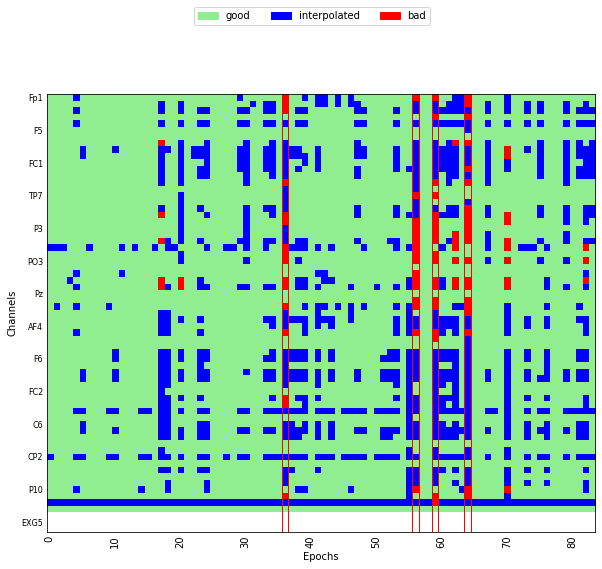

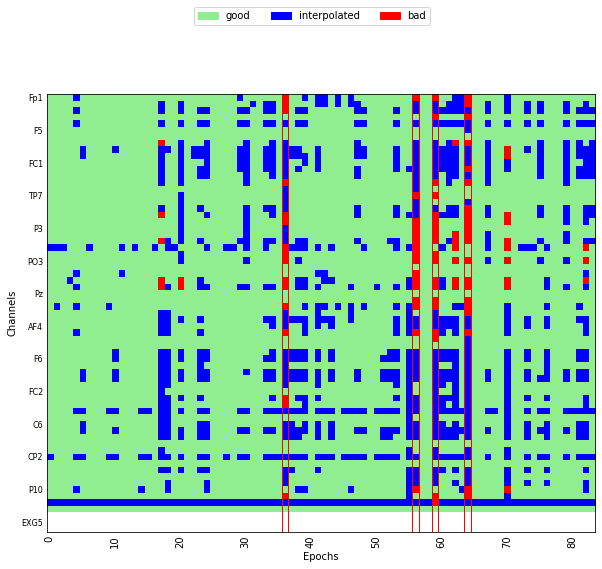

In [257]:
ar = AutoReject()
epochs_clean, reject_log = ar.fit_transform(epochs, return_log=True) 
fig, ax = plt.subplots(figsize=(15,8))
reject_log.plot('horizontal', ax=ax)

Not setting metadata
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


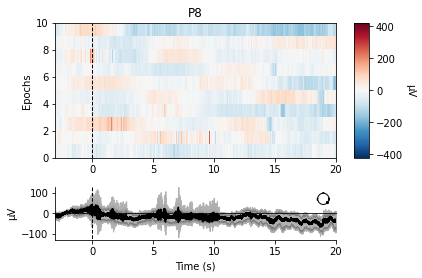

Not setting metadata
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


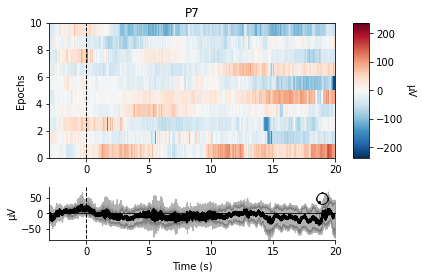

Not setting metadata
Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


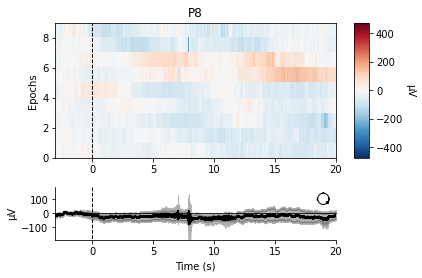

Not setting metadata
Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


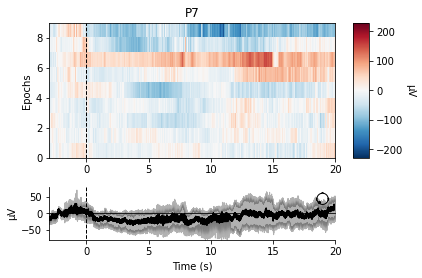

[<Figure size 432x288 with 4 Axes>]

In [263]:
epochs_clean['3/left'].plot_image(picks=['P8'])
epochs_clean['3/left'].plot_image(picks=['P7'])

epochs_clean['3/right'].plot_image(picks=['P8'])
epochs_clean['3/right'].plot_image(picks=['P7'])